In [1]:
import geopandas as gpd
import numpy as np

from shapely.geometry import Point

## Ookla vs Census 

In [2]:
tests = gpd.read_file("/media/jsaxon/brobdingnag/data/ookla/ookla/chicago.geojson")
place = gpd.read_file("/media/jsaxon/brobdingnag/data/ookla/places/chicago.geojson")

In [3]:
tracts = gpd.read_postgis("SELECT tr.geoid, tr.geom geom, log_mhi, black, total_pop "
                          "FROM census_place_2018 pl, census_tracts_2018 tr, acsprofile5y2017 pr "
                          "WHERE pl.top20 and pl.name = 'Chicago' AND pl.state = tr.state AND "
                          "tr.state = pr.state AND tr.county = pr.county AND tr.tract = pr.tract AND "
                          "ST_Area(ST_Intersection(pl.geom, tr.geom)) > ST_Area(tr.geom) / 2", 
                          crs = "EPSG:2163", geom_col = "geom", con = cen_con).to_crs("EPSG:3528")

In [4]:
bounds = tests.geometry.bounds

for s in set(bounds.columns):
    tests[s] = bounds[s]
    
tests["rangex"] = tests["maxx"] - tests["minx"]
tests["rangey"] = tests["maxy"] - tests["miny"]
tests["ookla_fixed_devices_q3"] = tests["ookla_fixed_devices_q3"].fillna(0)

In [5]:
points = []
for ri, row in tests.iterrows():
    
    for x in range(int(row.ookla_fixed_devices_q3)):
        points.append(Point(np.array([row.minx + row.rangex * np.random.random(),
                                      row.miny + row.rangey * np.random.random()])))
        
tests_geo = gpd.GeoDataFrame(geometry = points, crs = "EPSG:4326").to_crs(tracts.crs)

In [6]:
tests_points = gpd.sjoin(tests_geo, tracts, op = "within")
tests_points = tests_points.groupby("geoid").count().rename(columns = {"geometry" : "N"}).reset_index()
tests_points = tests_points[["geoid", "N"]]

tests_points = pd.merge(tests_points, tracts[["geoid", "log_mhi", "black", "total_pop"]]).dropna()

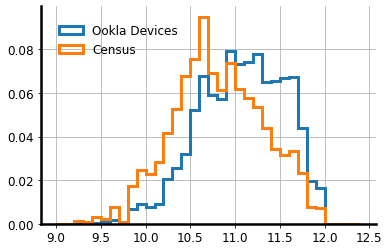

In [18]:
fig, ax = plt.subplots()

tests_points.log_mhi.hist(weights = tests_points.N / tests_points.N.sum(), 
                          bins = np.arange(9, 12.5, 0.1),
                          histtype = "step", lw = "3", label = "Ookla Devices", ax = ax)

tests_points.log_mhi.hist(weights = tests_points.total_pop / tests_points.total_pop.sum(), 
                          bins = np.arange(9, 12.5, 0.1),
                          histtype = "step", lw = "3", label = "Census", ax = ax)

ax.legend(loc = "upper left")

## SamKnows

In [8]:
us4326 = gpd.read_postgis("SELECT geoid, ST_Transform(geomsimp, 4326) geom FROM census_tracts_2018;",
                          con = cen_con, geom_col = "geom", crs = "EPSG:4326")

prof17 = pd.read_sql("SELECT geoid, log_mhi, black, total_pop FROM acsprofile5y2017;", con = cen_con)

In [9]:
sk = pd.read_excel("data/sk_sept2018.xlsx")
sk.rename(columns = {"unit id" : "unit_id"}, inplace = True)
sk.query("(geog_type == 'blockgroup') | (geog_type == 'tract')", inplace = True)

geo_sk= gpd.GeoSeries([Point(xy) for xy in sk[["longitude", "latitude"]].values], 
                      index = sk.index, crs = "EPSG:4326")

geo_sk = gpd.GeoDataFrame(data = sk, geometry = geo_sk, crs = "EPSG:4326")

In [10]:
sk_tr18 = gpd.sjoin(geo_sk, us4326, op = "within")[["unit_id", "geoid"]]
sk_tr18 = sk_tr18.sort_values("unit_id").reset_index(drop = True)
sk_tr18 = sk_tr18.sort_values("unit_id")

### Do we lose any observations by using 2017 vs 2018?  No.

In [11]:
pd.merge(sk_tr18, prof17).shape[0] == sk_tr18.shape[0]

True

In [14]:
sk_tr18 = pd.merge(sk_tr18, prof17)

### Plot SamKnows vs Census samples

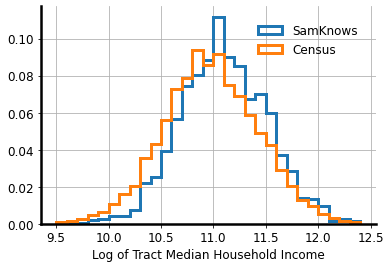

In [16]:
fig, ax = plt.subplots()

ax.set_xlabel("Log of Tract Median Household Income")

sk_tr18["w"] = 1.0 / sk_tr18.count().unit_id
sk_tr18.log_mhi.hist(bins = np.arange(9.5, 12.5, 0.1), histtype = "step",
                     weights = sk_tr18.w, lw = 3, label = "SamKnows", ax = ax)

prof17_no_na = prof17[["log_mhi", "total_pop"]].dropna()
prof17_no_na["w"] = prof17_no_na.total_pop / prof17_no_na.total_pop.sum()
prof17_no_na.log_mhi.hist(bins = np.arange(9.5, 12.5, 0.1), 
                          weights = prof17_no_na.w,
                          histtype = "step", lw = 3, ax = ax, label = "Census")

ax.legend()

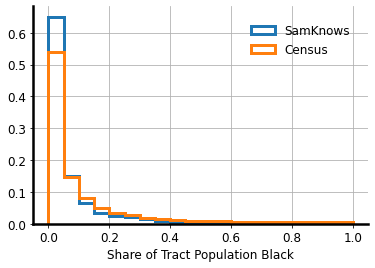

In [17]:
fig, ax = plt.subplots()

ax.set_xlabel("Share of Tract Population Black")

sk_tr18["w"] = 1.0 / sk_tr18.count().unit_id
sk_tr18.black.hist(bins = np.arange(0, 1.01, 0.05), histtype = "step",
                     weights = sk_tr18.w, lw = 3, label = "SamKnows", ax = ax)

prof17_no_na = prof17[["black", "total_pop"]].dropna()
prof17_no_na["w"] = prof17_no_na.total_pop / prof17_no_na.total_pop.sum()
prof17_no_na.black.hist(bins = np.arange(0, 1.01, 0.05), 
                          weights = prof17_no_na.w,
                          histtype = "step", lw = 3, ax = ax, label = "Census")

ax.legend()